In [158]:
import cv2 as cv
import numpy as np
import mediapipe as mp # python 3.8 | 3.11
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import math
from PIL import Image, ImageDraw

In [159]:
# regions of interest (roi)
forehead = [10,338,297,332,298,293,334,296,336,9,107,66,105,63,68,103,67,109,10]
left_cheek= [116,117,118,119,100,142,203,206,216,192,213,147,123,116]
right_cheek = [345,346,347,348,329,371,423,426,436,416,433,376,352,345]
face = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109, 10]


DESIRED_HEIGHT = 600
DESIRED_WIDTH = 600

def resize_and_show(image):
    h, w = image.shape[:2]
    if h < w:
      img = cv.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
    else:
      img = cv.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
      
    cv.imshow('output',img)
    cv.waitKey(0) 
    cv.destroyAllWindows()

In [160]:
def region_of_interest_segmentation(roi, info, img):
    imArray = np.asarray(img)
    
    polygon = []
    for i in range(len(roi)):
        idx_s = roi[i]
        start_point = (info[idx_s][3], info[idx_s][4])
        polygon.append(start_point)
    
    maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
    ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
    mask = np.array(maskIm)

    newImArray = np.zeros(img.shape, dtype='uint8')
    
    newImArray[:,:,0] = np.multiply(imArray[:,:,0], mask)
    newImArray[:,:,1] = np.multiply(imArray[:,:,1], mask)
    newImArray[:,:,2] = np.multiply(imArray[:,:,2], mask)

    return newImArray, mask


In [161]:

def segmentation(image):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces = 1, min_detection_confidence=0.5)

    results = face_mesh.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    landmarks = results.multi_face_landmarks[0]

    shape_a = image.shape[1] 
    shape_b = image.shape[0] 
    info = [] 

    for landmark in landmarks.landmark:
        x = landmark.x
        y = landmark.y
        z = landmark.z

        relative_x = int(shape_a * x)
        relative_y = int(shape_b * y)

        info.append([x,y,z,relative_x,relative_y])

    img1,_ = region_of_interest_segmentation(forehead, info, image)
    img2,_ = region_of_interest_segmentation(left_cheek, info, image)
    img3,_ = region_of_interest_segmentation(right_cheek, info, image)

    regions_interest = np.maximum(np.maximum(img1, img2), img3)
    
    return regions_interest


In [162]:
def segmentation2(image):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces = 1, min_detection_confidence=0.5)

    results = face_mesh.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    landmarks = results.multi_face_landmarks[0]

    shape_a = image.shape[1] 
    shape_b = image.shape[0] 
    info = [] 

    for landmark in landmarks.landmark:
        x = landmark.x
        y = landmark.y
        z = landmark.z

        relative_x = int(shape_a * x)
        relative_y = int(shape_b * y)

        info.append([x,y,z,relative_x,relative_y])

    img1,_ = region_of_interest_segmentation(face, info, image)

    regions_interest = img1
    
    return regions_interest

In [163]:
def colour_transfer_idt(i0, i1, bins=300, n_rot=10, relaxation=1):

    n_dims = i0.shape[1]
    
    d0 = i0.T
    d1 = i1.T
    
    for i in range(n_rot):
        r = sp.stats.special_ortho_group.rvs(n_dims).astype(np.float32)
        
        d0r = np.dot(r, d0)
        d1r = np.dot(r, d1)
        d_r = np.empty_like(d0)
        
        for j in range(n_dims):
            
            valid_d0r = d0r[j][~np.isnan(d0r[j])]
            valid_d1r = d1r[j][~np.isnan(d1r[j])]
            
            if len(valid_d0r) == 0 or len(valid_d1r) == 0:
                continue
            
            lo = min(valid_d0r.min(), valid_d1r.min())
            hi = max(valid_d0r.max(), valid_d1r.max())
            
            p0r, edges = np.histogram(valid_d0r, bins=bins, range=[lo, hi])
            p1r, _ = np.histogram(valid_d1r, bins=bins, range=[lo, hi])
                
            cp0r = p0r.cumsum().astype(np.float32)
            cp0r /= cp0r[-1]
            
            cp1r = p1r.cumsum().astype(np.float32)
            cp1r /= cp1r[-1]
            
            f = np.interp(cp0r, cp1r, edges[1:])
        
            d_r[j] = np.interp(d0r[j], edges[1:], f, left=lo, right=hi)
            
        d0 = relaxation * np.linalg.solve(r, (d_r - d0r)) + d0
    
    return d0.T

In [164]:

# google monk skin tone examples
path = "img/input.jpg"
img_input = cv.imread(path)

path = "img/target.jpg"
img_target = cv.imread(path)

width = int(img_input.shape[1] * 20 / 100)
height = int(img_input.shape[0] * 20 / 100)
dim = (width, height)

img_target = cv.resize(img_target, dim)
img_input = cv.resize(img_input, dim)

roi_input = cv.cvtColor(segmentation2(img_input), cv.COLOR_BGR2RGB)
roi_target = cv.cvtColor(segmentation2(img_target), cv.COLOR_BGR2RGB)

df_roi_ipt = pd.DataFrame(roi_input.reshape(-1, roi_input.shape[-1]), columns=['r', 'g', 'b'])
df_roi_tgt = pd.DataFrame(roi_target.reshape(-1, roi_target.shape[-1]), columns=['r', 'g', 'b'])

df_roi_ipt_nan = df_roi_ipt.mask((df_roi_ipt[['r', 'g', 'b']] == 0).all(axis=1))
df_roi_tgt_nan = df_roi_tgt.mask((df_roi_tgt[['r', 'g', 'b']] == 0).all(axis=1))

a_input = df_roi_ipt_nan.values
a_target = df_roi_tgt_nan.values

a_result = colour_transfer_idt(a_input, a_target, bins=300, n_rot=20, relaxation=1)

df_result = pd.DataFrame(a_result, columns=['r', 'g', 'b'])
img_output = a_result.reshape(roi_input.shape)

img_output = cv.convertScaleAbs(img_output)
img_output= cv.cvtColor(img_output, cv.COLOR_RGB2BGR)

resize_and_show(cv.cvtColor(roi_input, cv.COLOR_RGB2BGR))
resize_and_show(img_output)

In [165]:
img_final = cv.add(img_input, img_output)
resize_and_show(img_final)

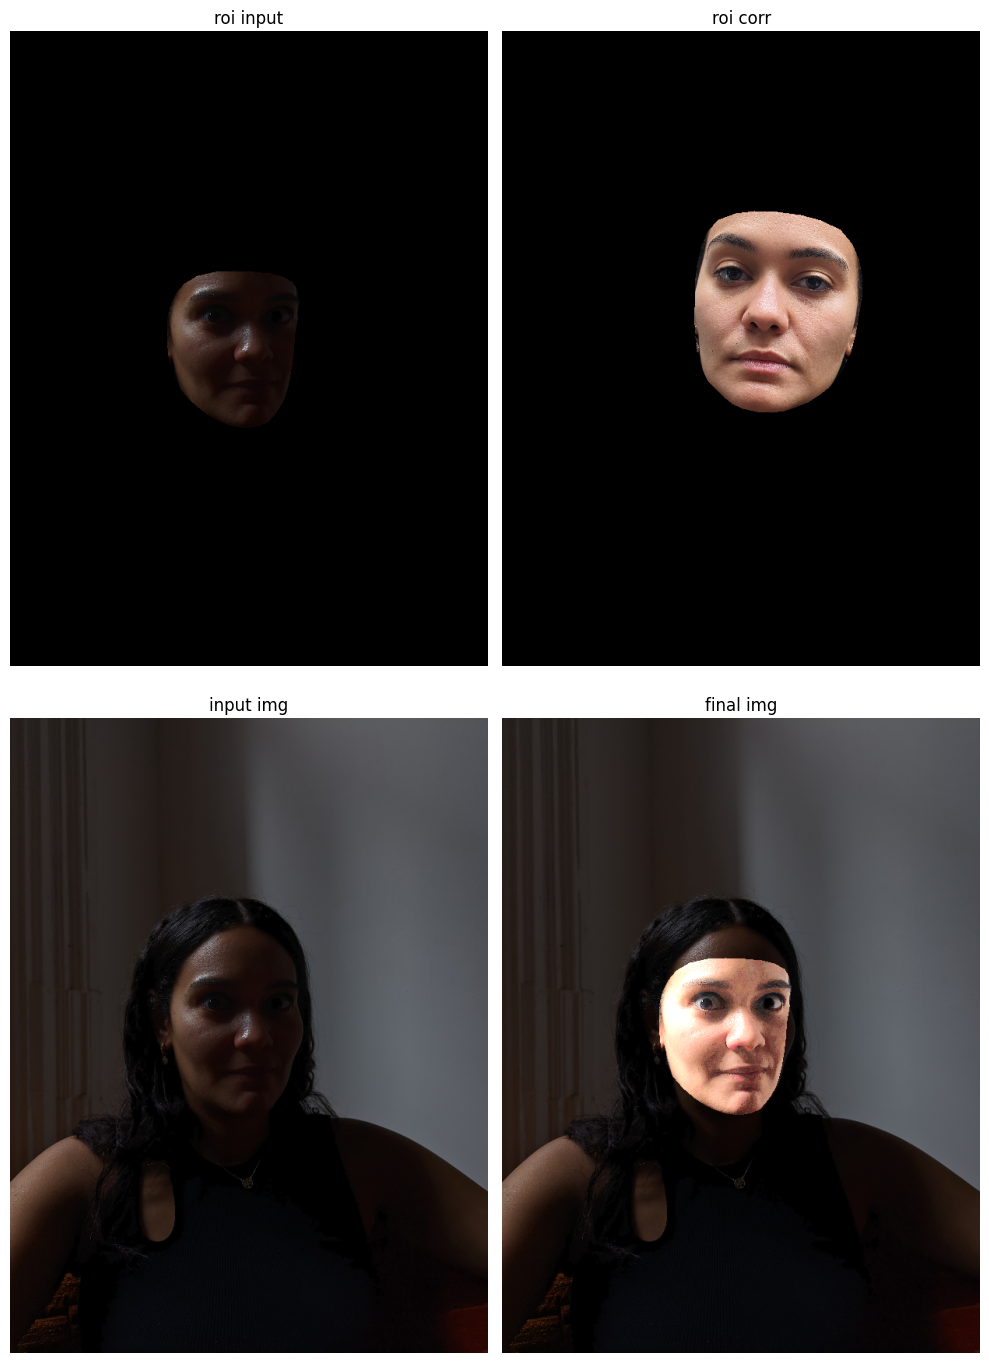

In [166]:
plt.figure(figsize=(10, 14))

plt.subplot(2, 2, 1)
plt.imshow(roi_input)
plt.title('roi input')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(roi_target)
plt.title('roi corr')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv.cvtColor(img_input, cv.COLOR_RGB2BGR))
plt.title('input img')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv.cvtColor(img_final, cv.COLOR_RGB2BGR))
plt.title('final img')
plt.axis('off') 


plt.tight_layout()
plt.show()

# 2 Segmentação

In [167]:
roi_input2 = roi_input.copy()

roi_input2 = cv.cvtColor(roi_input2,cv.COLOR_BGR2HSV)

roi_input2 = roi_input2.astype(np.float32)
mask = (roi_input2 == 0).all(axis=2)
roi_input2[mask] = np.nan


R =np.clip(np.nanmean(roi_input2[...,0]),0,255).astype(int)
g= np.clip(np.nanmean(roi_input2[...,1]),0,255).astype(int)
b =np.clip(np.nanmean(roi_input2[...,2]),0,255).astype(int)

Rs =np.clip(np.nanstd(roi_input2[...,0]),0,255).astype(int)
gs= np.clip(np.nanstd(roi_input2[...,1]),0,255).astype(int)
bs =np.clip(np.nanstd(roi_input2[...,2]),0,255).astype(int)


print(R,g,b,Rs,gs,bs)

112 135 40 17 42 28


(95, 93, 12) (129, 177, 68)


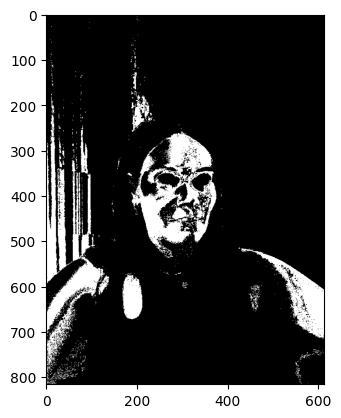

In [168]:
lower = (R-Rs, g - gs, b - bs)
upper = (R + Rs, g + gs, b + bs)
print(lower,upper)
roi_input2 = np.array(roi_input2)
mask2 = cv.inRange(cv.cvtColor(img_input,cv.COLOR_BGR2HSV),(-11, 94, 17), (27, 172, 100))

plt.imshow(mask2,cmap='gray')
#plt.imshow(img_input[mask2])

In [169]:
type(lower)

tuple